In [1]:
import matplotlib.pyplot as plt
from pandas import set_option
import pandas as pd
import tensorflow.keras.utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, model_from_json, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, LSTM, Embedding
import numpy as np 
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn 
import tensorflow.keras
from tensorflow.keras import regularizers

from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

import tensorflow as tf
import time as tm
import datetime
import os
from operator import itemgetter
from numpy import argmax

In [2]:
set_option("display.max_rows", 15)
pd.options.mode.chained_assignment = None

# training set is composed by databases: Repbase, RepetDB, and PGSB (consensus)
#filename = '../InpactorDB/InpactorDB_training.fasta.kmer2' 
filename = '../InpactorDB/InpactorDB_training.fasta.kmer2'
training_data = pd.read_csv(filename)
training_data

#dev and test set is composed by LTR_STRUCT database (consensus)
filename = '../InpactorDB/InpactorDB_LTR_STRUCT.fasta.kmers'
dev_test_data = pd.read_csv(filename)

In [3]:
path_log_base = './logs'
# class distribution
print(training_data.groupby('Label').size())

Label
1     2330
3      404
4      403
8       22
9     1244
12    1188
13    1299
14     608
16      90
17    1494
18    2451
19    1092
20    5517
dtype: int64


In [4]:
# class distribution
print(dev_test_data.groupby('Label').size())

Label
1     3447
3      426
4      333
8       35
9     1212
12    2329
13    1052
14     934
16     202
17    1629
18    3248
19    1419
20    6264
dtype: int64


In [5]:
label_vectors = training_data['Label'].values
feature_vectors = training_data.drop(['Label'], axis=1).values

label_dev_test = dev_test_data['Label'].values
feature_dev_test = dev_test_data.drop(['Label'], axis=1).values

label_vectors
feature_vectors

array([[1363,  953,  836, ...,    1,    1,    1],
       [1024,  611,  718, ...,    0,    4,    1],
       [1407, 1022,  879, ...,    2,    4,    1],
       ...,
       [1078,  925,  795, ...,    2,    1,    1],
       [1385, 1308, 1099, ...,    3,    0,    3],
       [3047, 2018, 2206, ...,   16,   20,   21]])

In [6]:
# Scaling
scaler = preprocessing.StandardScaler().fit(feature_vectors)
feature_vectors_scaler = scaler.transform(feature_vectors)

dev_test_scaler = scaler.transform(feature_dev_test)
#data split: 80% train, 10% dev and 10% test
validation_size = 0.2
seed = 7
#X_trainScaler, X_test_dev, Y_trainScaler, Y_test_dev = train_test_split(feature_vectors_scaler, label_vectors, 
                                                                                        #test_size=validation_size, 

                                                                                     #random_state=seed)

#Split data using training and dev-test sets separately option 1 (training alone and dev-test sets)

X_trainScaler = feature_vectors_scaler
Y_trainScaler = label_vectors

X_dev, X_test, Y_dev, Y_test = train_test_split(dev_test_scaler, label_dev_test, test_size=0.5, random_state=seed)

# Split data using training and dev-test sets separately option 2 (training and train-dev, and test alone)
"""X_trainScaler, X_dev, Y_trainScaler, Y_dev = train_test_split(feature_vectors_scaler, label_vectors, test_size=validation_size, random_state=seed)

X_test = dev_test_scaler
Y_test = label_dev_test"""



'X_trainScaler, X_dev, Y_trainScaler, Y_dev = train_test_split(feature_vectors_scaler, label_vectors, test_size=validation_size, random_state=seed)\n\nX_test = dev_test_scaler\nY_test = label_dev_test'

In [7]:
pca = decomposition.PCA(n_components=0.96,svd_solver='full',tol=1e-4)
pca.fit(X_trainScaler)
X_trainPCAScaler = pca.transform(X_trainScaler)
X_validationPCAScaler = pca.transform(X_dev)
X_testPCAScaler = pca.transform(X_test)

In [8]:
print(len(X_trainPCAScaler[0]))
print(X_trainPCAScaler.shape)

1902
(18142, 1902)


In [9]:
################################################## TLU ACTIVATION FUNCTION
T3 = 3;
def Tanh3(x):
    tanh3 = K.tanh(x)*T3
    return tanh3
##################################################

In [32]:
def metrics(Y_validation,predictions):
    print('Accuracy:', accuracy_score(Y_validation, predictions))
    print('F1 score:', f1_score(Y_validation, predictions,average='weighted'))
    print('Recall:', recall_score(Y_validation, predictions,average='weighted'))
    print('Precision:', precision_score(Y_validation, predictions, average='weighted'))
    print('\n clasification report:\n', classification_report(Y_validation, predictions))
    print('\n confusion matrix:\n',confusion_matrix(Y_validation, predictions))
    #Creamos la matriz de confusión
    snn_cm = confusion_matrix(Y_validation, predictions)

    # Visualizamos la matriz de confusión
    #snn_df_cm = pd.DataFrame(snn_cm, range(17), range(17))  
    #plt.figure(figsize = (20,14))  
    #sn.set(font_scale=1.4) #for label size  
    #sn.heatmap(snn_df_cm, annot=True, annot_kws={"size": 12}) # font size  
    #plt.show()

In [11]:
def graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID):
    numbers=AccTest
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Test Accuracy {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['accuracy']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Train Accuracy {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['val_accuracy']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Validation Accuracy {}, Época:{}\n".format(value, index+1))

    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 10))
        #Plot training & validation accuracy values
        plt.plot(np.concatenate([np.array([accuracyTRAIN]),np.array(history.history['accuracy'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyVALID]),np.array(history.history['val_accuracy'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyTEST]),np.array(AccTest)],axis=0)) #Test
        plt.title('Accuracy Vs Epoch')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.eps', format='eps')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.svg', format='svg')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.pdf', format='pdf')     
        #plt.show()
        
        plt.figure(figsize=(10, 10))
        #Plot training & validation loss values
        plt.plot(np.concatenate([np.array([lossTRAIN]),np.array(history.history['loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossVALID]),np.array(history.history['val_loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossTEST]),np.array(LossTest)],axis=0)) #Test
        plt.title('Loss Vs Epoch')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.eps', format='eps')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.svg', format='svg')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.pdf', format='pdf') 
        plt.show() 

In [12]:
def Final_Results_Test(PATH_trained_models):
    global AccTest
    global LossTest
    AccTest = []
    LossTest= [] 
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model = tf.keras.models.load_model(PATH_trained_models+'/'+filename, custom_objects={'Tanh3':Tanh3})
            loss,accuracy = model.evaluate(X_testPCAScaler, one_hot_labels_test,verbose=0)
            print(f'Loss={loss:.4f} y Accuracy={accuracy:0.4f}'+'\n')
            BandAccTest  = accuracy
            BandLossTest = loss
            AccTest.append(BandAccTest)    #Valores de la precisión en Test, para graficar junto a valid y train
            LossTest.append(BandLossTest)  #Valores de la perdida en Test, para graficar junto a valid y train
            
            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename
    
    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y Accuracy={B_accuracy:0.4f}'+'\n')

In [13]:
def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, model_name=""):
    start_time = tm.time()
    log_dir=path_log_base+"/"+model_name+"_"+str(datetime.datetime.now().isoformat()[:19].replace("T", "_").replace(":","-"))
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    filepath = log_dir+"/saved-model-{epoch:03d}-{val_accuracy:.4f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=False, mode='max')
    model.reset_states()
    
    #VALORES EN TRAIN TEST Y VALIDACIÓN INICIALES, GRÁFICOS
    global lossTEST
    global accuracyTEST
    global lossTRAIN
    global accuracyTRAIN
    global lossVALID
    global accuracyVALID
    lossTEST,accuracyTEST   = model.evaluate(X_test, y_test,verbose=None)
    lossVALID,accuracyVALID = model.evaluate(X_valid, y_valid,verbose=None)
    lossTRAIN,accuracyTRAIN = model.evaluate(X_train, y_train,verbose=None)
    
    global history
    global model_Name
    global log_Dir
    model_Name = model_name
    log_Dir = log_dir
    
    history=model.fit(X_train, y_train, epochs=epochs, 
                      callbacks=[tensorboard,checkpoint], 
                      batch_size=batch_size,validation_data=(X_valid, y_valid),verbose=1)
    
    metrics = model.evaluate(X_test, y_test, verbose=0)
     
    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    
    print("\n")
    print(log_dir)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [20]:
def InpactorFNN_Net():
    tf.keras.backend.clear_session()
    #Inputs
    inputs = tf.keras.Input(shape=(X_trainPCAScaler.shape[1],), name="input_1")
    #layer 1
    layers = tf.keras.layers.Dense(500,activation="relu", kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-5))(inputs)
    layers = tf.keras.layers.Dropout(0.5)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.8, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Outputs
    predictions = tf.keras.layers.Dense(21, activation="softmax", name="output_1")(layers)
    # model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    # optimizer 
    opt = tf.keras.optimizers.Adam(learning_rate=0.0008, beta_1=0.7, beta_2=0.9, epsilon=1e-08)
    # loss function
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    # Compile model
    model.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy'])
    return model


In [14]:
def Nakano_Net():
    tf.keras.backend.clear_session()

    # FNN implemented by Nakano

    #Inputs
    inputs = tf.keras.Input(shape=(X_trainPCAScaler.shape[1],), name="input_1")
    #layer 1
    layers = tf.keras.layers.Dense(200,activation="relu")(inputs)
    layers = tf.keras.layers.Dropout(0.5)(layers)
    #layer 2
    layers = tf.keras.layers.Dense(200,activation="relu")(layers)
    layers = tf.keras.layers.Dropout(0.5)(layers)
    #layer 3
    layers = tf.keras.layers.Dense(200,activation="relu")(layers)
    layers = tf.keras.layers.Dropout(0.5)(layers)
    # layer 4
    predictions = tf.keras.layers.Dense(21, activation="softmax", name="output_1")(layers)
    # model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    # optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,)
    # loss function
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    # Compile model
    #model.compile(loss=loss_fn, optimizer=opt, metrics=['acc', 'AUC', 'mse','mae','mape'])
    model.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy'])
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1902)]            0         
_________________________________________________________________
dense (Dense)                (None, 500)               951500    
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 500)               1500      
_________________________________________________________________
output_1 (Dense)             (None, 21)                10521     
Total params: 963,521
Trainable params: 962,521
Non-trainable params: 1,000
_________________________________________________________________
None


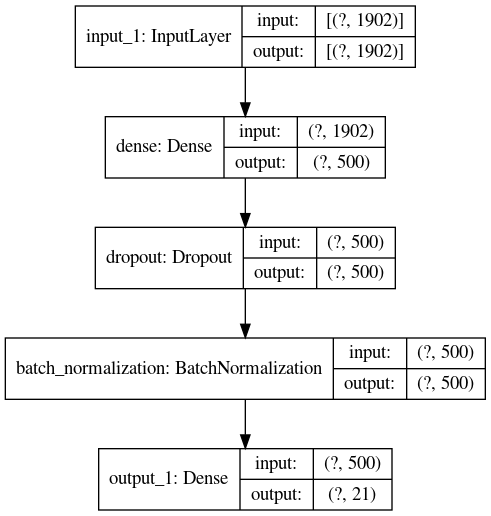

In [23]:
# arquitectura a afinar
model = InpactorFNN_Net()
# summarize layers
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

In [16]:
one_hot_labels_train = tf.keras.utils.to_categorical(Y_trainScaler, num_classes=21)
one_hot_labels_validation = tf.keras.utils.to_categorical(Y_dev, num_classes=21)
one_hot_labels_test = tf.keras.utils.to_categorical(Y_test, num_classes=21)

In [24]:
# Fit the model
train(model, X_trainPCAScaler, one_hot_labels_train, X_validationPCAScaler, one_hot_labels_validation, X_testPCAScaler, one_hot_labels_test, 56, 200, "InpactorFNN_Net")
Final_Results_Test(log_Dir) 

Epoch 1/200
324/324 [==============================] - 3s 8ms/step - loss: 0.6322 - accuracy: 0.8980 - val_loss: 0.9301 - val_accuracy: 0.7934
Epoch 2/200
324/324 [==============================] - 1s 3ms/step - loss: 0.2619 - accuracy: 0.9883 - val_loss: 0.9219 - val_accuracy: 0.8005
Epoch 3/200
324/324 [==============================] - 1s 3ms/step - loss: 0.1990 - accuracy: 0.9937 - val_loss: 0.9055 - val_accuracy: 0.8112
Epoch 4/200
324/324 [==============================] - 1s 3ms/step - loss: 0.1579 - accuracy: 0.9947 - val_loss: 0.9212 - val_accuracy: 0.8028
Epoch 5/200
324/324 [==============================] - 1s 4ms/step - loss: 0.1375 - accuracy: 0.9947 - val_loss: 0.8595 - val_accuracy: 0.8173
Epoch 6/200
324/324 [==============================] - 1s 3ms/step - loss: 0.1272 - accuracy: 0.9950 - val_loss: 0.8528 - val_accuracy: 0.8213
Epoch 7/200
324/324 [==============================] - 1s 3ms/step - loss: 0.1181 - accuracy: 0.9955 - val_loss: 0.8593 - val_accuracy: 0.8208

324/324 [==============================] - 1s 3ms/step - loss: 0.1105 - accuracy: 0.9951 - val_loss: 0.9961 - val_accuracy: 0.8347
Epoch 57/200
324/324 [==============================] - 1s 4ms/step - loss: 0.1135 - accuracy: 0.9950 - val_loss: 1.1054 - val_accuracy: 0.8301
Epoch 58/200
324/324 [==============================] - 1s 4ms/step - loss: 0.1099 - accuracy: 0.9955 - val_loss: 1.0068 - val_accuracy: 0.8403
Epoch 59/200
324/324 [==============================] - 1s 3ms/step - loss: 0.1095 - accuracy: 0.9953 - val_loss: 0.9469 - val_accuracy: 0.8406
Epoch 60/200
324/324 [==============================] - 1s 3ms/step - loss: 0.1141 - accuracy: 0.9947 - val_loss: 1.0084 - val_accuracy: 0.8352
Epoch 61/200
324/324 [==============================] - 1s 4ms/step - loss: 0.1084 - accuracy: 0.9959 - val_loss: 1.0109 - val_accuracy: 0.8408
Epoch 62/200
324/324 [==============================] - 1s 4ms/step - loss: 0.1081 - accuracy: 0.9960 - val_loss: 1.0216 - val_accuracy: 0.8354
Epoch

Epoch 113/200
324/324 [==============================] - 1s 3ms/step - loss: 0.1105 - accuracy: 0.9956 - val_loss: 1.0680 - val_accuracy: 0.8369
Epoch 114/200
324/324 [==============================] - 1s 4ms/step - loss: 0.1030 - accuracy: 0.9967 - val_loss: 1.0718 - val_accuracy: 0.8452
Epoch 115/200
324/324 [==============================] - 1s 3ms/step - loss: 0.1055 - accuracy: 0.9950 - val_loss: 0.9696 - val_accuracy: 0.8498
Epoch 116/200
324/324 [==============================] - 1s 3ms/step - loss: 0.1105 - accuracy: 0.9950 - val_loss: 1.0621 - val_accuracy: 0.8462
Epoch 117/200
324/324 [==============================] - 1s 3ms/step - loss: 0.1062 - accuracy: 0.9957 - val_loss: 1.0878 - val_accuracy: 0.8403
Epoch 118/200
324/324 [==============================] - 1s 3ms/step - loss: 0.1014 - accuracy: 0.9954 - val_loss: 1.0325 - val_accuracy: 0.8445
Epoch 119/200
324/324 [==============================] - 1s 3ms/step - loss: 0.1070 - accuracy: 0.9962 - val_loss: 1.1208 - val_ac

324/324 [==============================] - 1s 3ms/step - loss: 0.1088 - accuracy: 0.9951 - val_loss: 1.0475 - val_accuracy: 0.8433
Epoch 170/200
324/324 [==============================] - 1s 4ms/step - loss: 0.1057 - accuracy: 0.9953 - val_loss: 1.1076 - val_accuracy: 0.8393
Epoch 171/200
324/324 [==============================] - 1s 3ms/step - loss: 0.1117 - accuracy: 0.9945 - val_loss: 1.1555 - val_accuracy: 0.8421
Epoch 172/200
324/324 [==============================] - 1s 4ms/step - loss: 0.1058 - accuracy: 0.9959 - val_loss: 1.1325 - val_accuracy: 0.8462
Epoch 173/200
324/324 [==============================] - 1s 3ms/step - loss: 0.1021 - accuracy: 0.9963 - val_loss: 1.0556 - val_accuracy: 0.8455
Epoch 174/200
324/324 [==============================] - 1s 4ms/step - loss: 0.1049 - accuracy: 0.9951 - val_loss: 1.0688 - val_accuracy: 0.8434
Epoch 175/200
324/324 [==============================] - 1s 3ms/step - loss: 0.1008 - accuracy: 0.9962 - val_loss: 1.1551 - val_accuracy: 0.8403

Loss=0.9914 y Accuracy=0.8340

saved-model-061-0.8408.hdf5
Loss=0.9696 y Accuracy=0.8447

saved-model-062-0.8354.hdf5
Loss=1.0020 y Accuracy=0.8388

saved-model-063-0.8311.hdf5
Loss=1.0096 y Accuracy=0.8311

saved-model-064-0.8387.hdf5
Loss=1.0119 y Accuracy=0.8358

saved-model-065-0.8340.hdf5
Loss=1.0029 y Accuracy=0.8361

saved-model-066-0.8366.hdf5
Loss=0.9937 y Accuracy=0.8361

saved-model-067-0.8311.hdf5
Loss=1.0294 y Accuracy=0.8308

saved-model-068-0.8383.hdf5
Loss=0.9715 y Accuracy=0.8355

saved-model-069-0.8323.hdf5
Loss=0.9984 y Accuracy=0.8323

saved-model-070-0.8286.hdf5
Loss=1.0281 y Accuracy=0.8307

saved-model-071-0.8399.hdf5
Loss=0.9678 y Accuracy=0.8415

saved-model-072-0.8338.hdf5
Loss=0.9921 y Accuracy=0.8393

saved-model-073-0.8342.hdf5
Loss=1.0031 y Accuracy=0.8418

saved-model-074-0.8274.hdf5
Loss=1.0517 y Accuracy=0.8317

saved-model-075-0.8350.hdf5
Loss=1.0409 y Accuracy=0.8302

saved-model-076-0.8446.hdf5
Loss=1.0134 y Accuracy=0.8495

saved-model-077-0.8395.hd

Loss=1.0936 y Accuracy=0.8496

saved-model-200-0.8496.hdf5
Loss=1.0610 y Accuracy=0.8503



Best
saved-model-177-0.8545.hdf5
Loss=0.9475 y Accuracy=0.8571



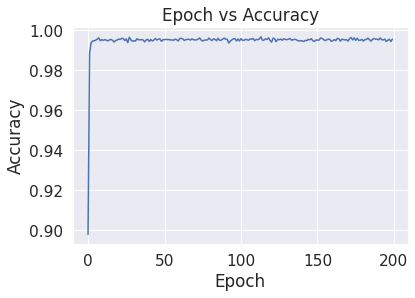

Test Accuracy 0.8570794463157654, Época:177

Test Accuracy 0.8568131327629089, Época:197

Test Accuracy 0.8551265001296997, Época:157

Test Accuracy 0.8550377488136292, Época:186

Test Accuracy 0.8548601865768433, Época:185

Test Accuracy 0.853883683681488, Época:189

Test Accuracy 0.8537949323654175, Época:162

Test Accuracy 0.8537949323654175, Época:176

Test Accuracy 0.8537061810493469, Época:115

Test Accuracy 0.8529072403907776, Época:184


Train Accuracy 0.9967478513717651, Época:114

Train Accuracy 0.9964722990989685, Época:28

Train Accuracy 0.9963068962097168, Época:173

Train Accuracy 0.9961966872215271, Época:8

Train Accuracy 0.9961966872215271, Época:119

Train Accuracy 0.9961966872215271, Época:175

Train Accuracy 0.9961415529251099, Época:74

Train Accuracy 0.9961415529251099, Época:153

Train Accuracy 0.9961415529251099, Época:192

Train Accuracy 0.9960864186286926, Época:80


Validation Accuracy 0.8545051217079163, Época:177

Validation Accuracy 0.853883683681488, Époc

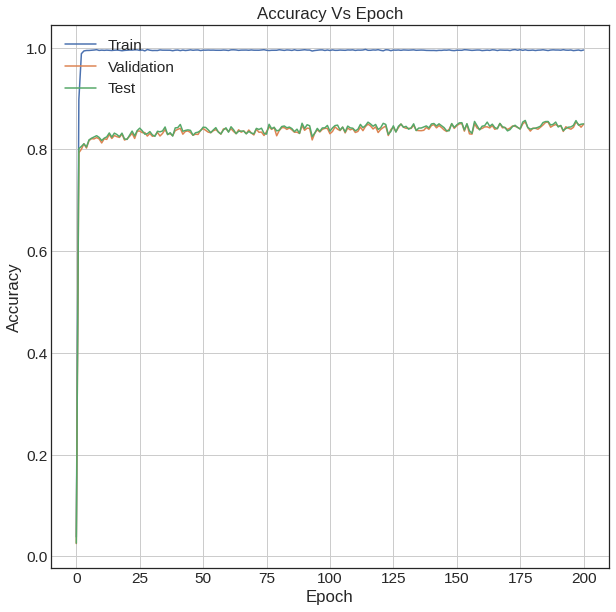

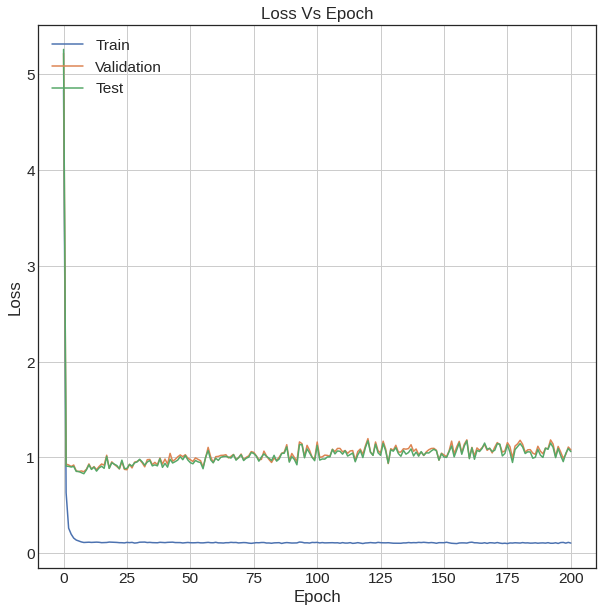

In [25]:
# plot metrics
plt.plot(history.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.show()

#GRÁFICOS DE LAS TRES CURVAS TRAIN TEST Y VALIDACIÓN
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)


In [33]:
scores = model.evaluate(X_trainPCAScaler, one_hot_labels_train, verbose=0)
print("Baseline Error train: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_validationPCAScaler, one_hot_labels_validation, verbose=0)
print("Baseline Error dev: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_testPCAScaler, one_hot_labels_test, verbose=0)
print("Baseline Error test: %.2f%%" % (100-scores[1]*100))

predictions = model.predict(X_trainPCAScaler)

metrics(Y_trainScaler, [argmax(x) for x in predictions])

predictions = model.predict(X_validationPCAScaler)

metrics(Y_dev, [argmax(x) for x in predictions])

predictions = model.predict(X_testPCAScaler)

metrics(Y_test, [argmax(x) for x in predictions])

Baseline Error train: 0.07%
Baseline Error dev: 15.04%
Baseline Error test: 14.97%
Accuracy: 0.9992834307132621
F1 score: 0.9994623268819894
Recall: 0.9992834307132621
Precision: 0.9996652156582434

 clasification report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00      2330
           2       0.00      0.00      0.00         0
           3       1.00      1.00      1.00       404
           4       1.00      1.00      1.00       403
           5       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.81      1.00      0.90        22
           9       1.00      1.00      1.00      1244
          10       0.00      0.00      0.00         0
          12       1.00      1.00      1.00      1188
          13       1.00      1.00      1.00      1299
          14       1.00      1.00      1.00       608
          16       1.00      0.99      0.99        90
          17       1